In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
from scipy import stats
import pylab 

### Цели
Количество смертностей на 100 000 населения от заболеваний сердечно-сосудистой системы, далее по тексте – **«Показатель»**. 
- определить среднее значение **«Показателя»** в 2018 году по миру ;
- определить изменилось ли среднее значение показателя в **«Показатель»** в 2018 году относительно 2014 года;
- определить изменился ли разброс (неоднородность) значений **«Показателя»** в 2018 году относительно 2014 года.

### Формирование датафрейма
Формирование датафрейма из ранее скаченных отдельных csv файлов.

In [8]:
# начало отсчета времени выполнения операции 
start_time = time()  

# формирование списка наименований папок, содержащих csv файлы
path_to_new_folder_with_data = 'tabs'
list_with_folders_names = glob.glob(path_to_new_folder_with_data + f'\\*')  

# формирование общего датафрейма из данных, содержащихся в csv файлах
total_frame = pd.DataFrame()

for i in tqdm(list_with_folders_names, leave=False, desc='concatenation'):
    list_with_file_csv_names = glob.glob(i + f'\\*.csv') 
    
    for j in list_with_file_csv_names:
        
        # загрузка и обработка данных из каждого csv файла 
        intermediate_dataset = pd.read_csv(j, encoding='utf-8', skiprows=[i for i in range(6)], usecols=[i for i in range(12)])
        intermediate_dataset = intermediate_dataset.rename(columns={'Number': 'Number of deaths'})
        intermediate_dataset['Cause of death'] = i.split('\\')[-1]
        intermediate_dataset = intermediate_dataset[['Cause of death', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age Group', 'Number of deaths', \
                                                     'Death rate per 100 000 population']]
        intermediate_dataset['Sex'] = intermediate_dataset['Sex'].apply(lambda a: 'Both' if a == 'All' else a)

        # присоединение данных из каждого csv файла к общему датафрейму
        total_frame = pd.concat([total_frame, intermediate_dataset], ignore_index=True)

# сохранение общего датафрейма
path_to_file_with_total_frame = path_to_new_folder_with_data + f'\\WHO_MORTALITY_DATABASE_total_dataframe.csv'
total_frame.to_csv(path_to_file_with_total_frame, index=False)

# печать времени затраченного на выполнение операции 
print(f'time: {time() - start_time}')

time: 0.4924945831298828


### Обработка датафрейма 
Из предшествующего опыта работы с данными, скаченными с портала ВОЗ, известно о необходимости проверки и обработки исходных данных. 

In [9]:
# загрузка ранее сформированного датафрейма  
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe.csv", \
    encoding='utf-8')

In [205]:
# проверка равенства заявленных и расчетных значений количества смертей по всем полам

z = df[(df['Sex']!='Both') & (df['Age Group']!='[All]') ].groupby(['Country Name', 'Year']).\
    agg({'Number of deaths':'sum'}).reset_index()
z['Ref'] = df[(df['Sex']=='Both') & (df['Age Group']=='[All]') ]['Number of deaths'].reset_index(drop=True)

print(round(len(z[z['Number of deaths'] != z['Ref']]) * 100 / len(z)), '%', sep='')
## в 55% случаев указанное суммарное количества смертей по всем полам не соответствует рассчитанному на основе приведенных данных
## необходимо исправить несоответствующие значения

55%


In [206]:
# обработка несоответствующих значений в столбцах "Number of deaths" и "Death rate per 100 000 population"

for i in z[z['Number of deaths'] != z['Ref']].reset_index(drop=True).index:
    
    # индекс строки где необходимо произвести замену  
    z1 = z[z['Number of deaths'] != z['Ref']].iloc[i]
    ind = df[(df['Country Name']==z1['Country Name']) & (df['Year']==z1['Year']) & (df['Sex']=='Both') & (df['Age Group']=='[All]')].index[0]
    
    # замена значения "Number of deaths"
    df.at[ind, 'Number of deaths'] = z1['Number of deaths']
    
    # замена значения  "Death rate per 100 000 population"
    df.at[ind, 'Death rate per 100 000 population'] = df.iloc[ind][7] * z1['Number of deaths'] / z1['Ref']   

In [207]:
# проверка результатов обработки  

x = df[(df['Sex']!='Both') & (df['Age Group']!='[All]') ].groupby(['Country Name', 'Year']).\
    agg({'Number of deaths':'sum'}).reset_index()
x['Ref'] = df[(df['Sex']=='Both') & (df['Age Group']=='[All]') ]['Number of deaths'].reset_index(drop=True)

print(round(len(x[x['Number of deaths'] == x['Ref']]) * 100 / len(x)), '%', sep='')
## в 100% случаев указанное суммарное количества смертей по всем полам соответствует рассчитанному на основе приведенных данных

100%


In [208]:
# сформируем две выборки с данными о количество смертностей на 100 000 населения от заболеваний сердечно-сосудистой системы в 2014 и 2018г.

df_18 = df[(df['Sex']=='Both') & (df['Age Group']=='[All]') & (df['Year']==2018)]['Death rate per 100 000 population']
df_14 = df[(df['Sex']=='Both') & (df['Age Group']=='[All]') & (df['Year']==2014)]['Death rate per 100 000 population']

### Проверка статистических гипотез 

#### Расчет среднего числа смертей на 100 000 человек по всему миру (2018г.)

ShapiroResult(statistic=0.853998064994812, pvalue=0.0004174014029558748)


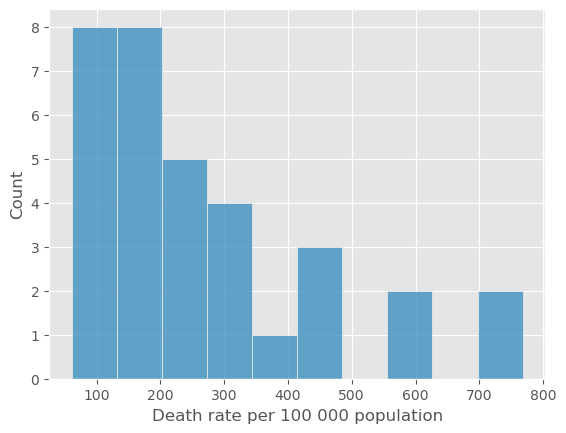

In [209]:
## для определения среднего количества смертей на 100 000 по всему миру, необходимо построить доверительный интервал 
## для построения доверительного интервала необходимо определить является ли распределение выборки нормальным 

# построим гистограмму распределения  
sns.histplot(df_18, bins=10)
## судя по гистограмме, распределение выборки не является нормальным
## дополнительно проверим распределение на нормальность с помощью критерия согласия 

# т.к. выборка достаточно мола воспользуемся критерием Шапиро-Уилка, определим уровень значимости на отметке 5%
print(stats.shapiro(df_18.values))
## гипотеза о нормальности распределения отвергается

In [211]:
## предположим что соблюдаются условия выполнения ЦПТ (выборка достаточно велика и выбросов нет)
## построим 95% асимптотический доверительный интервал для среднего 

stats.norm.interval(0.95, loc=df_18.values.mean(), scale=stats.sem(df_18.values))
## с 95% уверенностью можно утверждать, что среднее по генеральной совокупности находится в интервале (204.4, 328.6)

(204.36813741200078, 328.5550221243349)

In [212]:
## т.к. выборка является репрезентативной, мы можем проверить предположение о выполнении ЦПТ с помощью бутстрапа

def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

# бутстрапируем
df_18_bootstrap = get_bootstrap_sample(df_18, B_sample=10**6)
df_18_mean = np.mean(df_18_bootstrap, axis=0)
df_18_median = np.median(df_18_bootstrap, axis=0)

KstestResult(statistic=0.015364435534505672, pvalue=1.7444217576167326e-205)


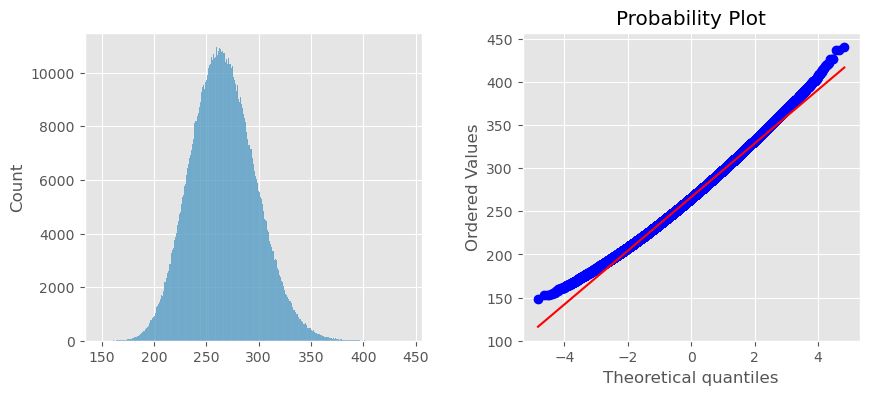

In [213]:
# графики
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, hspace=0.5, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df_18_mean)
ax2 = fig.add_subplot(gs[0, 1])
stats.probplot(df_18_mean, dist="norm", plot=pylab)
## гистограмма распределения визуально похожа на гистограмму нормального распределения 
## однако вызывает подозрение диаграмма квантиль-квантиль (qq-plot)

# проверим распределение средних на нормальность с помощь КS-теста, определим уровень значимости на отметке 5%
print(stats.kstest(df_18_mean, 'norm', args=(np.mean(df_18_mean), df_18_mean.std())))
## гипотеза о нормальности распределения средних отвергается 
## это свидетельствует о наличии выбросов. в таком случае использовать асимптотический доверительный интервал для определения среднего в генеральной совокупности - не корректно.
## будем использовать медиану

In [214]:
## построим доверительные интервалы по выборке медиан, полученной в ходе бутстрапа

def stat_intervals_Ef(x, alpha=0.05):
    left = np.quantile(x, alpha/2)
    right = np.quantile(x, 1-alpha/2)
    return left, right

stat_intervals_Ef(df_18_median)
## с 95% уверенностью можно утверждать, что медиана по генеральной совокупности находится в интервале (152.5, 283.5)

(152.51389781, 283.54387453286444)

### Сравнение среднего числа смертей на 100 000 человек в 2018 и 2014гг.

Н0: медианы равны 

НА: медиана по 2018г. больше медианы по 2014г.

In [215]:
# медианы по выборкам 
print('2018:', np.median(df_18))
print('2014:',np.median(df_14))

2018: 214.85917294419949
2014: 213.6100299150145


Text(0.5, 0, '2014')

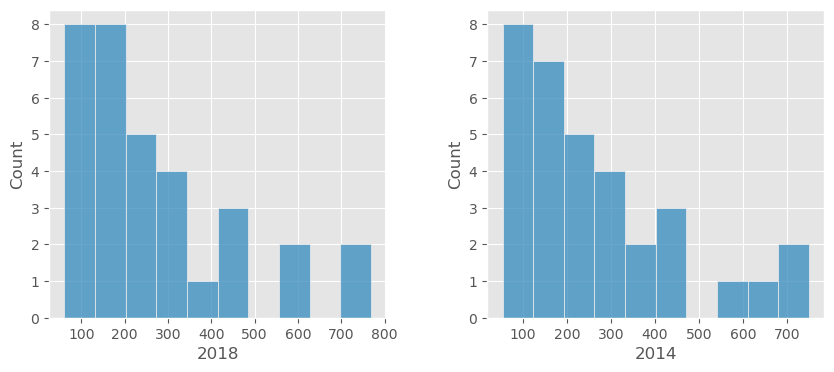

In [216]:
# построим гистограммы распределений (2014 и 2018гг.) 
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, hspace=0.5, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df_18, bins=10)
ax1.set_xlabel("2018")
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df_14, bins=10)
ax2.set_xlabel("2014")

In [217]:
# проверим распределения на нормальность с помощь критерия Шапиро-Уилка, определим уровень значимости на отметке 5%
print('2018:', stats.shapiro(df_18.values))
print('2014:', stats.shapiro(df_14.values))
## оба распределения не подчиняются закону нормального распределения
## в таком случае, при условии, что выборки являются связанными, для проверки гипотезы о равенстве медиан можно воспользоваться двух выборочным критерием Уилкоксона, определим уровень значимости на отметке 5%

stats.wilcoxon(x=df_18.values, y=df_14.values, zero_method="wilcox")
## p-value превышает уровень значимости, следовательно, нулевая гипотеза не отвергается

2018: ShapiroResult(statistic=0.853998064994812, pvalue=0.0004174014029558748)
2014: ShapiroResult(statistic=0.8756017684936523, pvalue=0.0013151818420737982)


WilcoxonResult(statistic=229.0, pvalue=0.3669361248612404)

In [218]:
# проверим Н0 с помощью бутстрапа

def get_bootstrap_depend(x, y, n, tip):
    
    # хранилище для итоговых значений разностей 
    itg_razn = np.zeros(n)
    
    # парная выборка из которой будем делать подвыборки 
    v1 = np.array([(x[i], y[i]) for i in range(len(x))]) 
    
    for i in range(n):
    
        # выбираем случайные индексы из парной выборки 
        ind = np.random.randint(v1.shape[0], size=len(v1))
        
        # формируем одну парную бутстрап выборку (1 бутстрап выборка состоит из 2 связанных выборок)
        boot_vib = np.array([v1[i] for i in ind])
        
        # находим разность средних этих двух новых связанных выборок 
        if tip == 'mean':
            razn = np.diff(np.mean(boot_vib, axis=0))
        
        # находим разность медиан этих двух новых связанных выборок 
        elif tip == 'median':
            razn = np.diff(np.median(boot_vib, axis=0))
            
        # находим разность дисперсий этих двух новых связанных выборок 
        elif tip == 'var':
            razn = np.diff(np.var(boot_vib, axis=0, ddof=1))

        # сохраняем полученную разность из единичной бутстрап выборки
        itg_razn[i] = razn
        
    return itg_razn
    
stat_intervals_Ef(get_bootstrap_depend(x=df_14.values, y=df_18.values, n=10**6, tip='median'), alpha=0.05)    

## 0 входит в доверительный интервал, значит на уровне значимость 5% разница между медианами статистически незначима 
## будстрап подтвердил результат теста Уилкоксона

(-38.1791798951092, 12.08647184534837)

### Сравнение неоднородность исследуемого показателя в 2018г. по сравнению с 2014г.

Н0: дисперсии равны

НА: дисперсия по 2018г. меньше дисперсии по 2014г.

In [219]:
# дисперсии по выборкам
print('2018:', np.var(df_18.values, ddof=1))
print('2014:', np.var(df_14.values, ddof=1))

2018: 33121.441670715285
2014: 34537.754739077165


In [220]:
# построим доверительные интервалы для дисперсий двух выборок 

# 2018г.
alpha = 0.05 
n = len(df_18.values)
var_hat = np.var(df_18.values, ddof=1)
chi_l, chi_u = stats.chi2.ppf([1-alpha/2, alpha/2], df = n - 1)
left = (n - 1) * var_hat/chi_l
right = (n - 1) * var_hat/chi_u
print(f"2018: ({left}, {right})")

# 2014г.
n = len(df_14.values)
var_hat = np.var(df_14.values, ddof=1)
chi_l, chi_u = stats.chi2.ppf([1-alpha/2, alpha/2], df = n - 1)
left = (n - 1) * var_hat/chi_l
right = (n - 1) * var_hat/chi_u
print(f"2014: ({left}, {right})")

2018: (21420.306323248682, 57946.517755573026)
2014: (22336.26463434947, 60424.38122477839)


In [221]:
# т.к. распределения выборок отличны от нормальных для проверки гипотезы о равенстве можно воспользоваться непараметрическим критерием Флигнера-Килина

stats.fligner(df_18.values, df_14.values)
## p-value превышает уровень значимости, следовательно, нулевая гипотеза не отвергается

FlignerResult(statistic=0.04701572092399768, pvalue=0.8283399831851284)

In [222]:
# проверим Н0 с помощью бутстрапа

stat_intervals_Ef(get_bootstrap_depend(x=df_18.values, y=df_14.values, n=10**6, tip='var'), alpha=0.05) 
## будстрап подтвердил результат теста Флигнера-Килина

(-1628.6798786691318, 5231.99458123098)

### Итог проверка статистических гипотез
- можно утверждать, что в 2018 году, по миру, средний показатель смертности на 100 000 населения от заболеваний сердечно-сосудистой системы находился в интервале от 152.5 до 283.5 человек;  
- можно утверждать, что средний показатели смертности на 100 000 населения от заболеваний сердечно-сосудистой системы в 2018 году не изменился относительно 2014 года; 
- можно утверждать, что разброс (неравенство), по миру, показателей смертности на 100 000 населения от заболеваний сердечно-сосудистой системы в 2018 году не изменился относительно 2014 года.

Все утверждения делаются с 95% уверенностью.




